In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/.virtualenvs/nca-alife-clip/bin/python3


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
import util
import untrained_nca

In [77]:
import imageio
def save_video(save_dir, name, video, fps=100):
    writer = imageio.get_writer(f'{save_dir}/{name}.mp4', fps=fps)
    for frame in video:
        writer.append_data(frame)
    writer.close()

In [14]:
data_dir = "/home/akarshkumar0101/nca-alife-data/untrained/d_embd=08/"

In [301]:
args = untrained_nca.parser.parse_args('')
for k, v in util.load_json(data_dir, "args").items():
    setattr(args, k, v)
args.n_steps_chunk = 100
# args.height, args.width = 64, 64
# args.d_state = 4
print(args)

Namespace(seed=0, save_dir='/home/akarshkumar0101/nca-alife-data/untrained/d_embd=08', height=256, width=256, dt=0.01, p_drop=0.0, init_state='randn', n_layers=2, d_state=16, d_embd=8, kernel_size=3, nonlin='gelu', n_steps=10000000000, n_steps_chunk=100, bs=1)


In [302]:
nca = untrained_nca.NCA(n_layers=args.n_layers, d_state=args.d_state, d_embd=args.d_embd, kernel_size=args.kernel_size,
                 nonlin=args.nonlin)

In [317]:
p_drop, dt, H, W = args.p_drop, args.dt, args.height, args.width
def forward_step(state, _rng):
    H, W, D = state.shape
    state = (state-state.mean(axis=(0, 1)))/state.std(axis=(0, 1))
    dstate = jax.jit(nca.apply)(params, state)
    # print(f"{state.mean().item(): 0.3f}, {state.std().item(): 0.3f}")
    next_state = dstate.clip(-5, 5)
    next_state = (next_state-next_state.mean(axis=(0, 1)))/next_state.std(axis=(0, 1))
    print(f"{next_state.mean().item(): 0.3f}, {next_state.std().item(): 0.3f}")
    return next_state, state

def forward_chunk(state, _rng):
    return jax.lax.scan(forward_step, state, split(_rng, args.n_steps_chunk))
batch_forward_chunk = jax.jit(jax.vmap(forward_chunk))

In [335]:
rng = jax.random.PRNGKey(0)

In [344]:
params = util.load_pkl(data_dir, "params")
state = util.load_pkl(data_dir, "state_00400000000")
# rng, _rng = split(rng)
# state = jax.random.normal(_rng, (1, H, W, args.d_state))

In [347]:
state[0].std(axis=(0, 1))

array([0.0625 , 0.0884 , 0.0493 , 0.0492 , 0.03125, 0.0068 , 0.03128,
       0.01572, 0.0221 , 0.02458, 0.0246 , 0.125  , 0.00829, 0.0625 ,
       0.0511 , 0.0191 ], dtype=float16)

In [380]:
a = state[0,:, :, :].flatten()

In [381]:
((a-a.mean())**2).mean()

0.0562

In [385]:
a.min(), a.max()

(-0.483, 0.6953)

In [387]:
state.astype(jnp.float32).std()

0.23709019

In [358]:
state[0, :, :, 3].std()

0.007465

In [337]:
state = state[0]
for i in range(20):
    state,_ = forward_step(state, rng);


-0.000,  1.000
-0.000,  1.000
-0.000,  1.000
 0.000,  1.000
 0.000,  1.000
-0.000,  1.000
-0.000,  1.000
-0.000,  1.000
 0.000,  1.000
 0.000,  1.000
-0.000,  1.000
 0.000,  1.000
-0.000,  1.000
-0.000,  1.000
 0.000,  1.000
 0.000,  1.000
-0.000,  1.000
 0.000,  1.000
-0.000,  1.000
-0.000,  1.000


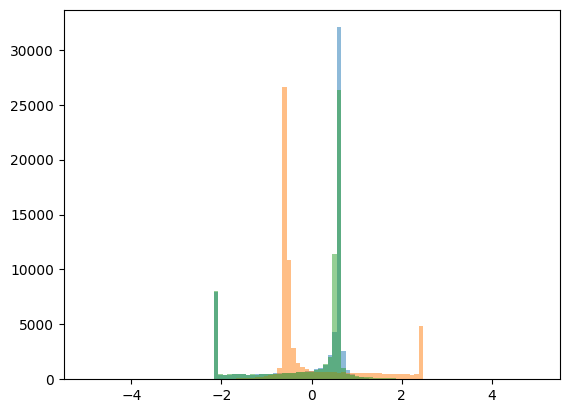

In [338]:
for i in range(3):
    plt.hist(np.array(state[:, :, i].flatten()), bins=np.linspace(-5, 5, 100), alpha=0.5);

In [ ]:
p(N|x) = p(x|N)*p(N)/p(x)

In [207]:
rng, _rng = split(rng)
nstate, state_vid = batch_forward_chunk(state, split(_rng, args.bs))

In [208]:
state_vid.shape, state_vid.dtype, state_vid.min(), state_vid.max()

((1, 100, 64, 64, 16),
 dtype('float32'),
 Array(-5., dtype=float32),
 Array(5., dtype=float32))

In [209]:
vid = np.array((state_vid[0, :, :, :, :4]+1)/2.*255).astype(np.uint8)
vid = rearrange(vid, 'T H W (R C) -> T (R H) (C W)', R=2, C=2)

In [210]:
vid.shape, vid.dtype, vid.min(), vid.max()

((100, 128, 128), dtype('uint8'), 0, 255)

In [211]:
save_video(args.save_dir, 'video', vid, fps=1)

/usr/lib/python3.9/subprocess.py:1756: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


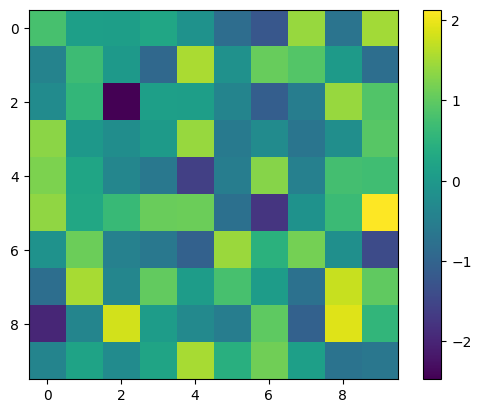

In [144]:
a = np.array(state_vid[0, 0, :, :, 3])
plt.imshow(a[:10, :10])
plt.colorbar()

In [119]:
a.mean(), a.std()

(Array(0.3035, dtype=float16), Array(0.01026, dtype=float16))

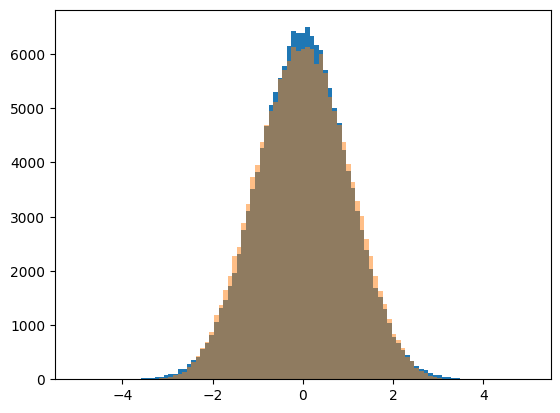

In [182]:
a = jax.random.normal(_rng, (10000, 16))
plt.hist(np.array(a.flatten()), bins=np.linspace(-5, 5, 100), alpha=1.0);
a = a/jnp.linalg.norm(a, axis=-1, keepdims=True)
plt.hist(np.array(a.flatten()*4), bins=np.linspace(-5, 5, 100), alpha=0.5);

In [469]:
def train_step(x, _):
    def loss_fn(x):
        # return -x.var()
        logp = jax.scipy.stats.gaussian_kde(x).logpdf(x)
        entr = -(jnp.exp(logp)*logp).mean()
        return -entr
    loss, grads = jax.value_and_grad(loss_fn)(x)
    lr = 1e-2
    x = x-lr*grads
    x = x.clip(-1, 1)
    return x, loss
    
rng = jax.random.PRNGKey(0)
x = jax.random.uniform(rng, (10, ), minval=-1, maxval=1)

In [470]:
y, losses = jax.lax.scan(train_step, x, jnp.arange(10000))

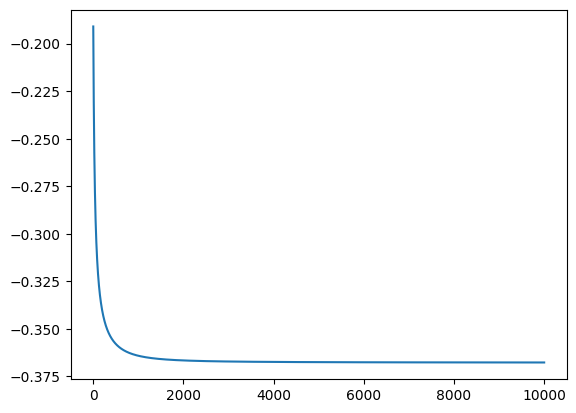

In [475]:
plt.plot(losses)
# plt.yscale('log')

(-1.0, 1.0)

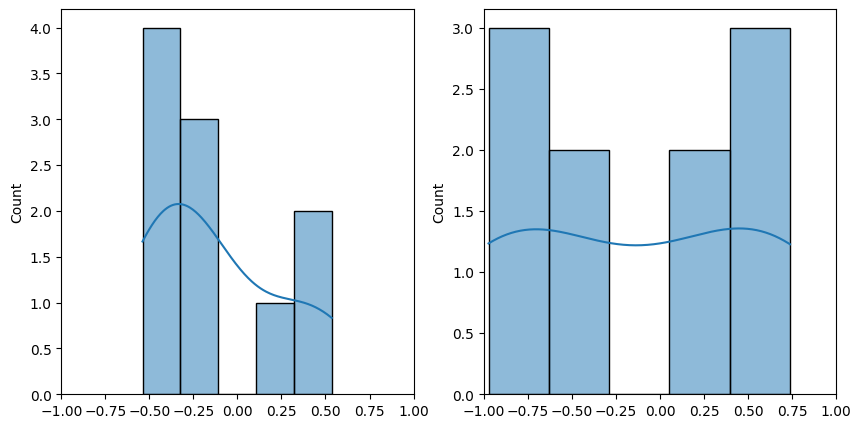

In [472]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.histplot(np.array(x), kde=True)
plt.xlim(-1, 1)
plt.subplot(122)
sns.histplot(np.array(y), kde=True)
plt.xlim(-1, 1)

  0%|          | 0/100000 [00:00<?, ?it/s]

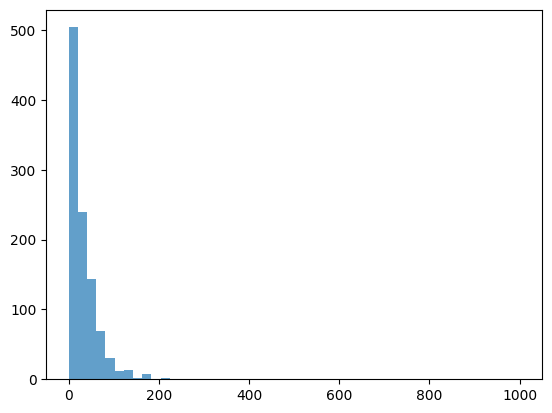

In [38]:
bs = 32
pool = np.zeros((1024))

for _ in tqdm(range(100000)):
    idx = np.random.randint(0, len(pool), size=bs)
    batch = pool[idx]
    batch = batch + 1
    if np.random.uniform()<1.0:
        batch[np.random.randint(0, bs)] = 0
    pool[idx] = batch
plt.hist(pool, bins=np.linspace(0, 1000, 50), alpha=0.7);

In [168]:
bs = 32
def get_pool(_rng):
    pool = jnp.zeros((1024,))
    def do_iter(pool, _rng):
        _rng1, _rng2 = split(_rng)
        idx = jax.random.randint(_rng1, shape=(bs,), minval=0, maxval=len(pool))
        pool = pool.at[idx].set(pool[idx] + 1)
        idx = jax.random.randint(_rng2, shape=(1,), minval=0, maxval=len(pool))
        pool = pool.at[idx].set(0.)
        # pool = pool%300
        return pool, None
    pool, _ = jax.lax.scan(do_iter, pool, split(_rng, 10000))
    return pool

In [169]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
pool = jax.vmap(get_pool)(split(_rng, 10))

In [170]:
pool.mean()

Array(31.282618, dtype=float32)

In [171]:
pool = np.array(pool)

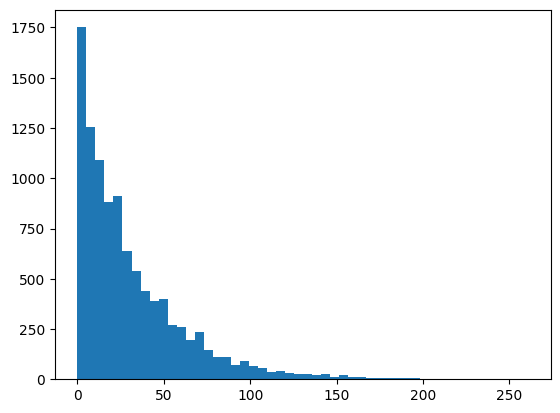

In [173]:
plt.hist(pool.flatten(), bins=50);

In [132]:
y, _ = np.histogram(pool, np.arange(300))

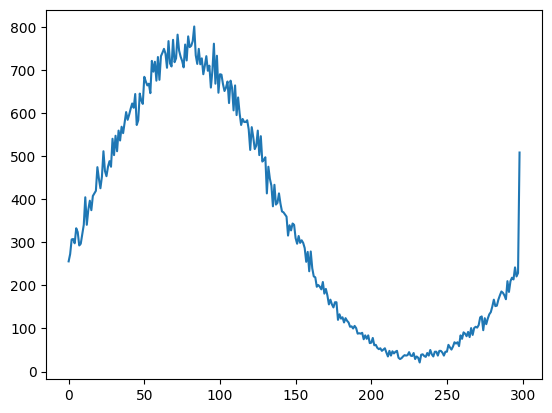

In [133]:
plt.plot(np.arange(299), y)
# plt.yscale('log')

In [82]:
pool.shape

(100, 1024)

In [181]:
jax.tree.map(lambda x: x+3, None)